# MNIST Database

The `MNIST` database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. Widely used for training and testing in the field of machine learning.

- handrawn digits (Note: `EMNIST` includes upper and lower case digits)
- 28x28 pixel
- grayscale
- ~70,000 labelled images.

## Loading this via `torchvision`

A pytorch extension that consists of popular datasets, yet critically baking into them the separation of training and testing datasets to enforce a bit more consistency across research, as everyone uses the same split - allows for comparable benchmarking of models.

`torchvision` allows you to "transform" your data as you load it in, which is typically required as you interface your dataset with your NN. We will explicitly avoid the use of this utility to describe nessecary transformations explicitly later. I'm still learning after all.

In [1]:
from torchvision import datasets

train_dataset = datasets.MNIST('./data', train=True, download=True)
test_dataset = datasets.MNIST('./data', train=False)

These are in what is known as a PIL format - tbh I'm not too sure about this format 🤷‍♂️ - but you can draw them and see the raw internal structure in the following way;

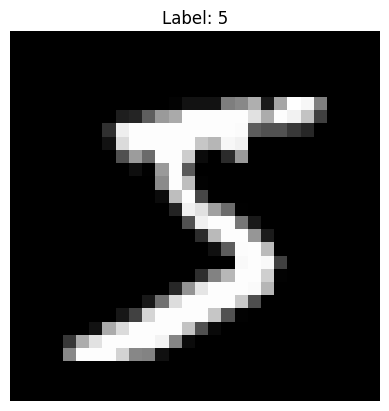

In [2]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

plt.imshow(image, cmap="grey") # To note; even though images are 3D in practice in shape, because these images only operate on one colour channel; these are structurally 2D formats.
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

But don't be fooled, the underlying structure is simple - especially considering the grayscale nature of the image. Each incident cell of the 28x28 matrix has a value between 0 and 255.

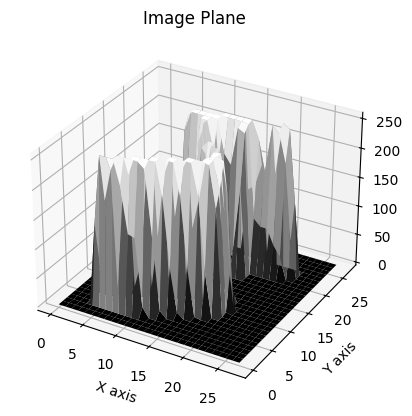

In [3]:
import numpy as np

image_array = np.array(image) # from PIL image object back to an array

x = np.arange(image_array.shape[1])
y = np.flip(np.arange(image_array.shape[0]))
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, image_array, cmap='gray')

ax.set_title('Image Plane')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

plt.show()

# Defining NN Inputs and thinking about Normalization

We can easily feed each of these cells input into a respective input neuron - but we should think about the mechanics of each neuron in our neural network.

## Common activation functions
Are typically exhibit most behaviour between ranges -1 to 1, increasing towards 0

## Normalization
Commonly min-max is used to introduce this concept, seen to commonly produce ranges of results between [0,1] - but stepping beyond this, *z-score* normalization is what you see in industry the most. We transform the data to have a mean of 0 and a standard deviation of 1.

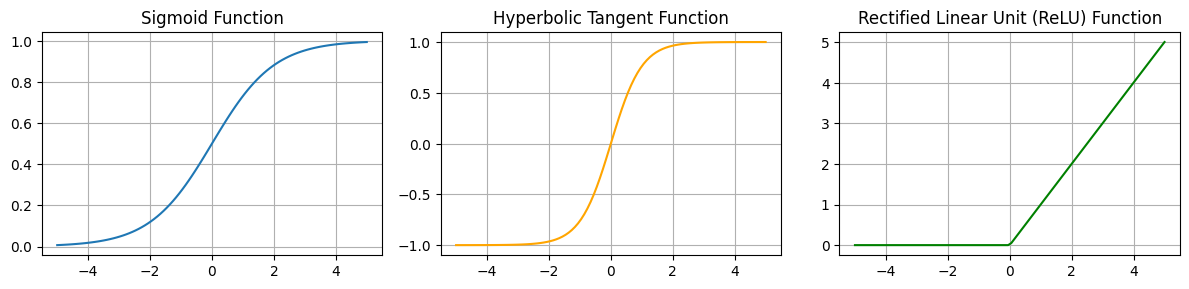

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)


x = np.linspace(-5, 5, 100) # generates a range of values from -5 to 5 for x

y_sigmoid = sigmoid(x)
y_tanh = tanh(x)
y_relu = relu(x)


plt.figure(figsize=(12, 8))

plt.subplot(3, 3, 1)
plt.plot(x, y_sigmoid, label='Sigmoid')
plt.title('Sigmoid Function')
plt.grid(True)

plt.subplot(3, 3, 2)
plt.plot(x, y_tanh, color='orange', label='tanh')
plt.title('Hyperbolic Tangent Function')
plt.grid(True)

plt.subplot(3, 3, 3)
plt.plot(x, y_relu, color='green', label='ReLU')
plt.title('Rectified Linear Unit (ReLU) Function')
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
import torch
from torchvision import transforms

sums = 0
sums_sq = 0
n_samples = 0

for data, _ in train_dataset:
    data_tensor = transforms.ToTensor()(data) # NOTE; as above, this tensor has a [1, 28, 28] dimension space - effectively 2D
    sums += torch.sum(data_tensor)
    sums_sq += torch.sum(data_tensor ** 2)
    n_samples += data_tensor.numel()

mean = sums / n_samples
std = ((sums_sq / n_samples) - (mean ** 2)) ** 0.5

print(f'Mean: {mean:.4f}, Std: {std:.4f}')

Mean: 0.1307, Std: 0.3081


## Transforming the test/train datasets
We will also add a `denormalize` definition here for utility further on when we want to look at certain images.

In [6]:
normalize_transform = transforms.Normalize((mean,), (std,))

def normalize_dataset(dataset):
    normalized_data = []
    for img, label in dataset:
        img_tensor = transforms.ToTensor()(img)
        normalized_img = normalize_transform(img_tensor)
        normalized_data.append((normalized_img, label))
    return normalized_data

def denormalize(images):
    images = images * std + mean
    images = np.clip(images, 0, 1)
    images = (images * 255).type(torch.uint8)
    return images
    

normalized_train_dataset = normalize_dataset(train_dataset)
normalized_test_dataset = normalize_dataset(test_dataset)

### Mini-batch SGD will be our training approach
The `DataLoader` class in `pytorch` conveniently handles the stochastic, mini-batch sourcing of our training data, wrapping in it the shuffling then batch sourcing for training our NN. Note;

The choice of batch size is a trade-off:

- Larger batches provide a more accurate estimate of the gradient but require more memory and can lead to a less exploratory update path, potentially getting stuck in shallow local minima.
- Smaller batches offer more update opportunities and better generalization at the cost of increased noise in the updates and potentially longer training times.

In [7]:
import torch

batch_size = 2**5

train_loader = torch.utils.data.DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

## Re-introducing you to typical NN's
Interestingly, `pytorch` which is the SOTA ML framework today, is actually built upon on the early lua implementation of [the torch library](https://en.wikipedia.org/wiki/Torch_(machine_learning)). Came in during 2017 and has unequivocally been the top tool for ML research since.

Note; `pytorch` comes with a comprehensive `nn` package that handles common activation functions, architecture implementation for various SOTA NN's - this library is also hella extensible.

### Our architecture
Ofcourse we want to stay simple here as we progress to more complex S-NN's, so we will define a;
- 28*28 ($\approx$ 2^10) input layer (corresponding to each pixel cell) that yields 2^8 outputs.
- 2^8 hidden layer that yields 10 outputs.
- final output of size 10 is the result of this NN.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 2**8)
        self.fc2 = nn.Linear(2**8, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) # flattens each tensor to a 1D array ready for network feeding
        # NOTE: the -1 infers batch_size by the passed in x, -1 to keep dyanmic.
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # note lack of activation function as output layer just "summarizes" results. 
        return x

model = SimpleNN()

# Loss Function and Optimization Method Notes
I'm familiar with two main loss functions, one for regression and one for classification. Both operate on;

- $N$ is the number of observations.
- $y_i$ is the actual label for the $i^{th}$ observation.
- $\hat{y}_i$ is the predicted value for the $i^{th}$ observation.

They look arbitrary, but they are specifically desgined to be "smooth" functions that allows differentiability to allow us to perform **gradient descent** when looking at the derivative of the loss function with respect to the set weights.

### Regression Loss
The classic mean-square-error equation.
$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2 \text{ and note; }
\frac{\partial \text{MSE}}{\partial \hat{y}_i} = \frac{2}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)
$$

### Classification Loss
I've only really known of the Cross-Entropy Loss ($CEL$) function - enter the binary variant;

$$
\text{CEL}_\text{Binary} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$
With it's partial derivative;
$$
\frac{\partial \text{CEL}_\text{Binary}}{\partial \hat{y}_i} = -\frac{1}{N} \sum_{i=1}^{N} \left[ \frac{y_i}{\hat{y}_i} - \frac{1 - y_i}{1 - \hat{y}_i} \right]
$$

- Note: $y_i$ is now either 0 or 1, and,
- $\hat{y}_i$ is a probability in [0,1]. 

Which leads us to generalise for $C$ different classes.
$$
\text{CEL}_\text{Multi} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})
$$

With it's partial derivative;
$$
\frac{\partial \text{CEL}_\text{Multi}}{\partial \hat{y}_{i,c}} = -\frac{1}{N} \sum_{i=1}^{N} \frac{y_{i,c}}{\hat{y}_{i,c}}
$$

- $y_{i,c}$ is a binary indicator of whether class $c$ is the correct classification for observation $i$.
- $\hat{y}_{i,c}$ is the predicted probability of observation $i$ being of class $c$.

## Optimization
Gradient descent is applied...

# Criterion being the Cross Entropy Loss
Mini-batched backward propogating gradient descent.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # LR; learning rate (hyper parameter)

# Keeping evaluation simple for now

In [10]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    
    for images, labels in loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = (correct / total) * 100
    return accuracy

# Training the model
Each step, or `epoch` has a forward pass to evaluate the step loss which gets propogated back up the NN to perform a gradient descent via chain rule.

In [11]:
pre = evaluate(model, train_loader)
print(f'Accuracy before training: {pre:.2f}%')

epochs = 10

loss_history = []
accuracy_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.
    correct_predictions = 0
    total_predictions = 0

    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels) # forward pass
        
        loss.backward() # propogate backwards the loss, set models gradients at each parameter
        optimizer.step() # use respective model weight associated gradients to perform a descent step
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Accuracy before training: 10.26%
Epoch [1/10], Loss: 0.4357, Accuracy: 88.60%
Epoch [2/10], Loss: 0.2330, Accuracy: 93.31%
Epoch [3/10], Loss: 0.1813, Accuracy: 94.94%
Epoch [4/10], Loss: 0.1482, Accuracy: 95.83%
Epoch [5/10], Loss: 0.1249, Accuracy: 96.52%
Epoch [6/10], Loss: 0.1083, Accuracy: 97.00%
Epoch [7/10], Loss: 0.0953, Accuracy: 97.38%
Epoch [8/10], Loss: 0.0849, Accuracy: 97.70%
Epoch [9/10], Loss: 0.0762, Accuracy: 97.92%
Epoch [10/10], Loss: 0.0690, Accuracy: 98.13%


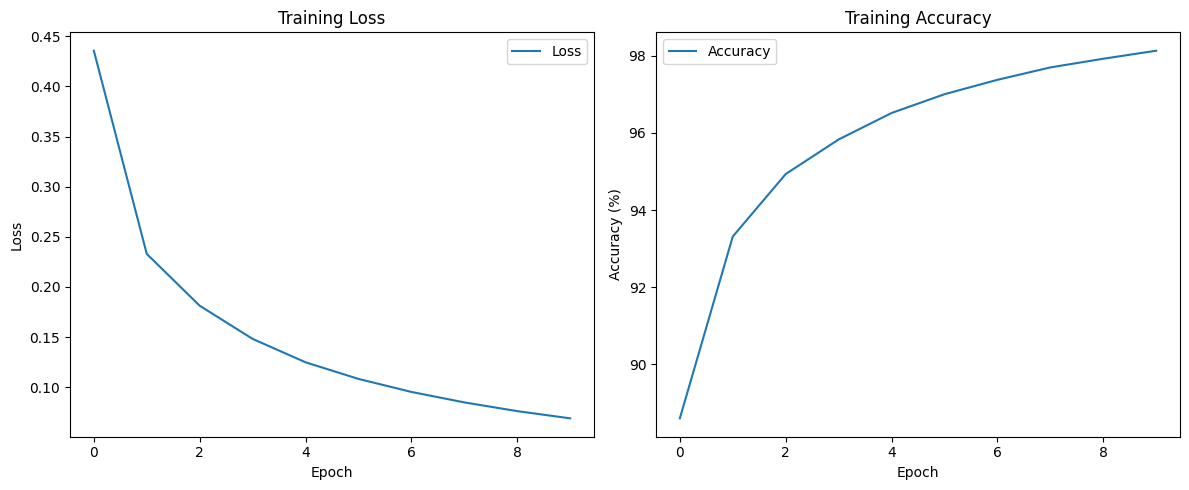

In [12]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation (and taking a look at some misclassifcations)
There are various metrics we can gather, but the cleanest is just the raw accuracy. But when comparing models, we will need to get a bit better here to prove statstically significant differences. Sometimes it's also good to just take a step back and actually look ourselves at the kinds of images the model was unable to classify to get some sort of potential guidance of how to proceed.

In [13]:
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    
    misclassified = (predicted != labels).nonzero().squeeze()
    if misclassified.numel() == 0:
        continue
    if misclassified.dim() == 0:  # Make sure misclassified is always 1D
        misclassified = misclassified.unsqueeze(0)
        
    for i in misclassified:
        img = images[i]
        img = np.transpose(img, (1, 2, 0))  # Change CxHxW to HxWxC format
        img = denormalize(img)  # Apply denormalization
        misclassified_images.append(img)
        misclassified_labels.append(labels[i].item())
        misclassified_preds.append(predicted[i].item())

print(f'Accuracy of the network on the test images: {100 * correct / total}%')
print(f'-- note; failed to classify {len(misclassified_images)} image(s)')

Accuracy of the network on the test images: 97.43%
-- note; failed to classify 257 image(s)


# Taking a look at missclassifications
Which such a simple NN, we already have quite some incredible accuracy, and so now we can start evaluating some things. First a glimpse into the missclassifications.

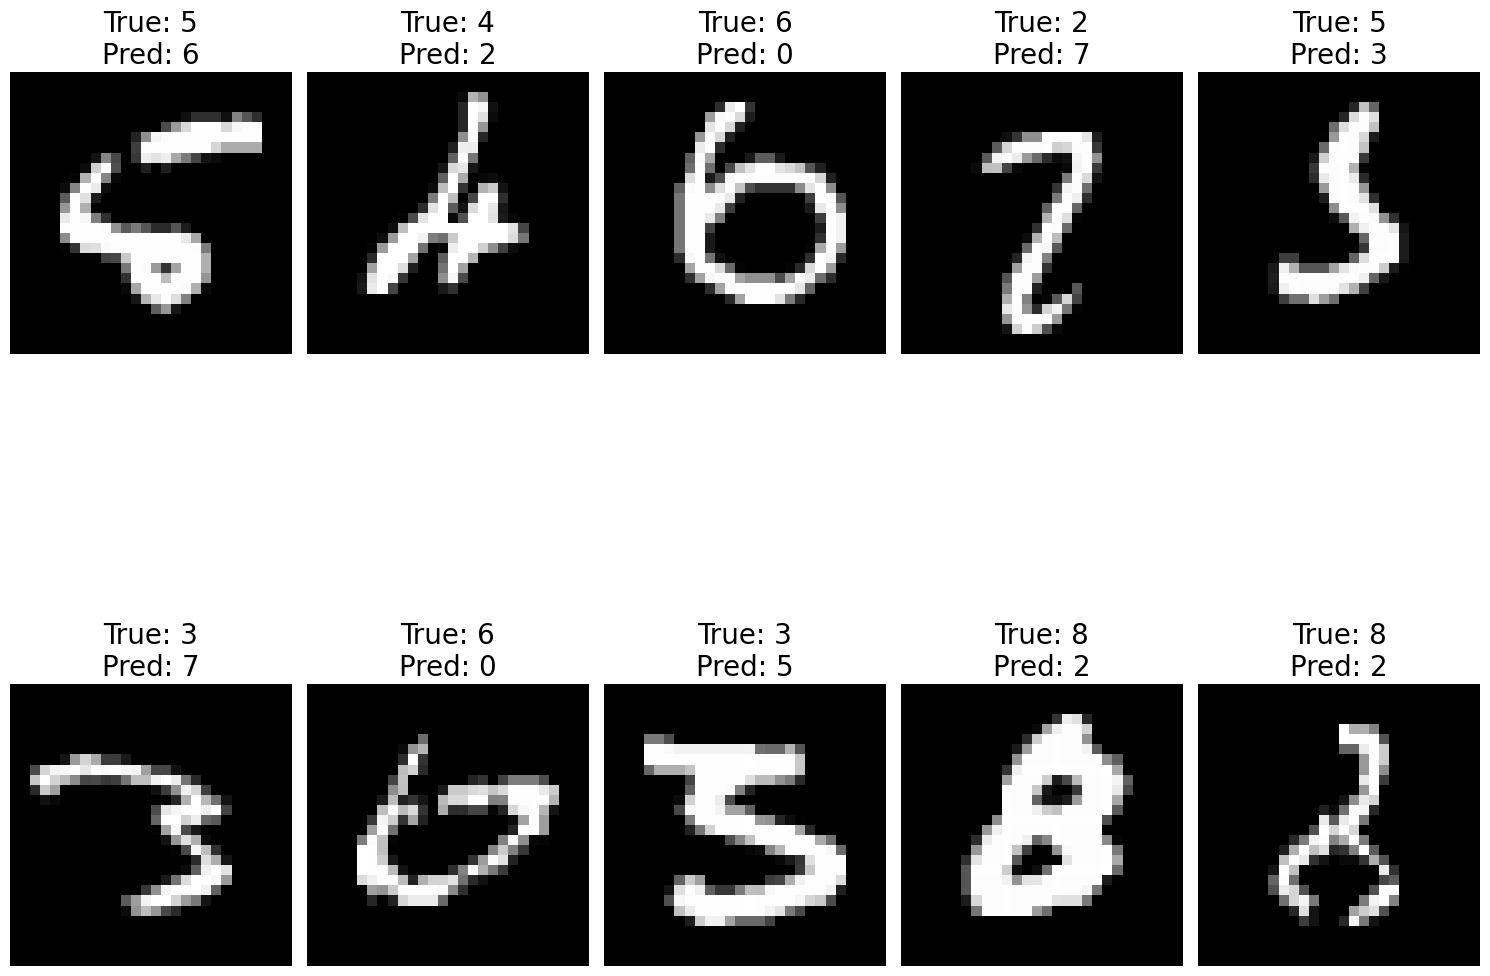

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(15, 15))
axs = axs.flatten()
for i in range(10):
    img, pred, label = misclassified_images[i], misclassified_preds[i], misclassified_labels[i]
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"True: {label}\nPred: {pred}", fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Adveserial Attacks
A relatively new subject that highlights a models "robustness". Broadly speaking there are two classes of attacks;
- **"whitebox"** attacks: are specifically designed against a models implementation. It must know a models set of parameters/weights and the "white-box" term reflects that transparency.
- **"blackbox"** attacks: best contrasted against "whitebox" as being model agnostic. Techniques employed that are independent to the model implementation. Typically more preferred study due to their greater flexibility in everyday environments.

# Fast Gradient Sign Method (FGSM)
For a simple adversarial attack, we'll use the Fast Gradient Sign Method (FGSM), which is a common technique for generating adversarial examples. FGSM works by using the gradients of the neural network to create an adversarial example (hence "white-box". For an input image $x$, the adversarial example $x'$ is created as follows:

$$
x' = x + \epsilon \cdot sign(\nabla_x J(\theta, x, y))
$$

Where:
- $theta$: model parameters
- $J$: loss function
- $\epsilon$: small pertubation magnitude
- $\nabla_x J(\theta, x, y)$: gradient of the loss wrt. input image.

The idea is to take a small step in the direction of the gradient's sign, enough to mislead the model without significantly altering the perceptual quality of the image.

## My issue with $\epsilon$
It doesn't really give me much about how "different" the perturbed image is, hence I want to bound the FGSM attack by a [structural similarity index measure](https://en.wikipedia.org/wiki/Structural_similarity_index_measure) (SSIM). It is a perception-based model that considers image degradation as perceived change in structural information.

We know the $\epsilon$ describes the size of the step to take for image degradation, so we can descent on this value until our perturbed image stays within our desired SSIM threshold.

In [15]:
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity

def fgsm_attack(model, loss, images, labels, eps):
    images.requires_grad = True # attach a gradient graph
    output = model(images)
    loss = loss(output, labels)
    
    model.zero_grad()
    loss.backward() # calculate gradients of model via backpropogating gradients

    data_grad = images.grad
    perturbed = images + eps * data_grad.sign()
    return perturbed.detach() # detached tensor from that gradient graph

ssim_threshold = 0.90

def ssim_bound_fgsm_attack(model, loss, original, labels):
    epsilon = 0.5 # starting epsilon huge
    
    def ssm(perturbed, original):
        old, new = denormalize(original.detach()), denormalize(perturbed)
        
        # scikit-image doesn't handle tensors, so move them to cpu and convert tensor to numpy
        old = old.cpu().numpy()
        new = new.cpu().numpy()

        # Ensure the data range is appropriate for SSIM
        data_range = np.max([new.max() - new.min(), old.max() - old.min()])
        similarity = [structural_similarity(o.squeeze(), p.squeeze(), data_range=data_range, win_size=11, channel_axis=None) for o, p in zip(old, new)]
        return np.mean(similarity)
    
    perturbed = fgsm_attack(model, loss, original, labels, epsilon)
    while ssm(perturbed, original) < ssim_threshold:
        epsilon *= 0.9
        perturbed = fgsm_attack(model, loss, original, labels, epsilon) 
    
    # print(f'epsilon value of: {epsilon} satisfied SSIM threshold of: {ssim_threshold}')
    return perturbed

# Applying
We now want to capture those **instances of correctly classified images that have been perturbed in a way that causes a misclassification**.

In [16]:
misclassified_original_images = []
misclassified_perturbed_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()

correct_after_perturbation = 0
total = 0

for images, labels in test_loader:
    original = images.clone()
    perturbed = ssim_bound_fgsm_attack(model, criterion, images, labels)

    outputs_original = model(original)
    _, predicted_original = torch.max(outputs_original, 1)

    outputs_perturbed = model(perturbed)
    _, predicted_perturbed = torch.max(outputs_perturbed, 1)

    total += labels.size(0)
    correct_after_perturbation += (predicted_perturbed == labels).sum().item()
    
    correctly_classified_original = (predicted_original == labels)
    misclassified_after_perturbation = (predicted_perturbed != labels)
    truly_misclassified = correctly_classified_original & misclassified_after_perturbation
    
    for i in range(labels.size(0)):
        if truly_misclassified[i]:
            original_img = original[i]
            perturbed_img = perturbed[i]
            
            misclassified_original_images.append(denormalize(original_img))
            misclassified_perturbed_images.append(denormalize(perturbed_img))
            misclassified_labels.append(labels[i].item())
            misclassified_preds.append(predicted_perturbed[i].item())

print(f'Accuracy of the network on the perturbed test images: {100 * correct_after_perturbation / total}%')
print(f'-- note; caused misclassification of {len(misclassified_perturbed_images)} additional image(s)')

Accuracy of the network on the perturbed test images: 2.73%
-- note; caused misclassification of 9470 additional image(s)


# Taking a look at advaserial missclassifications
We will display these as pixel intensities as heatmaps instead to use a range of colours to highlight how the perturbed image is different.

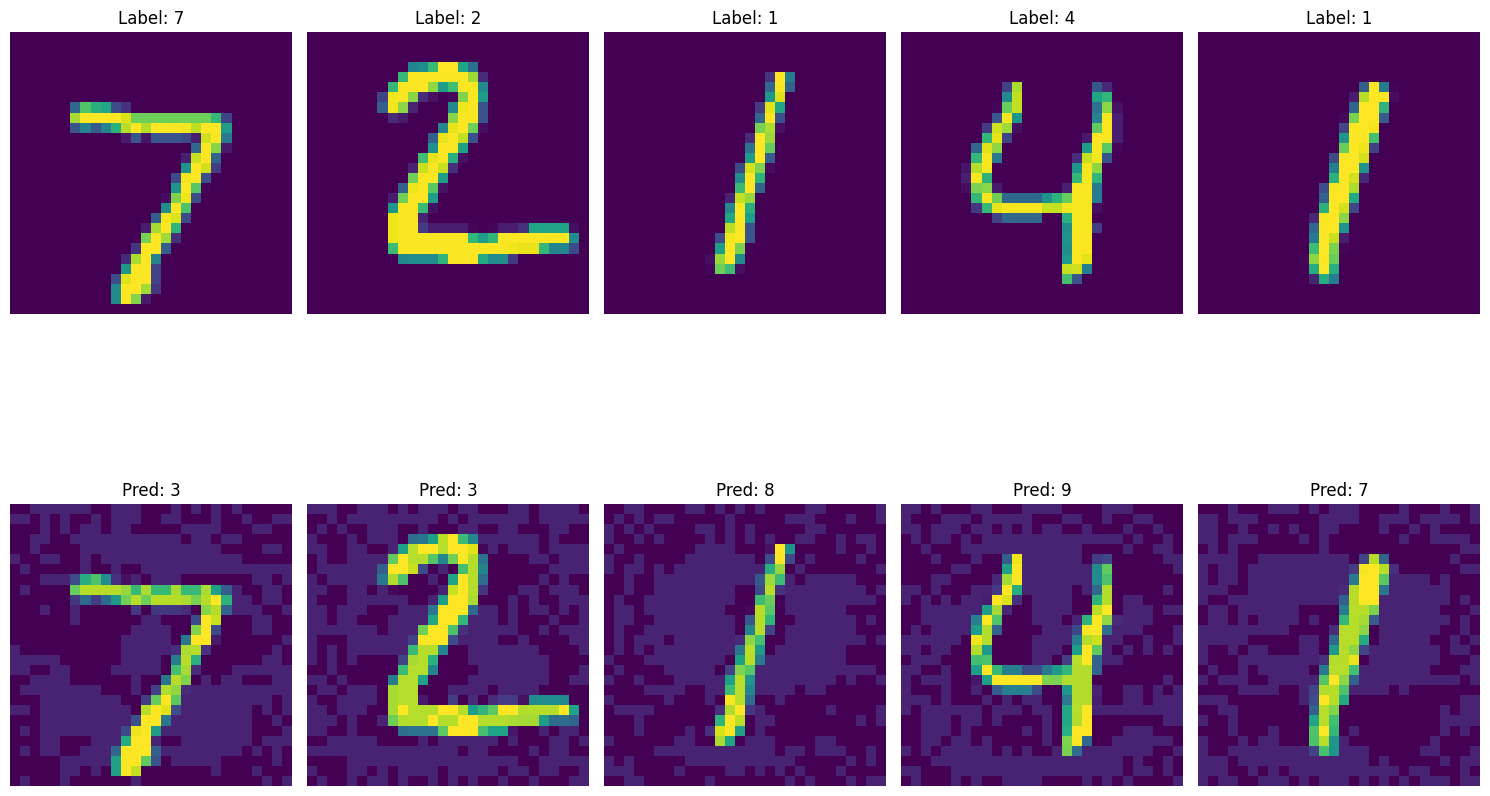

In [17]:
def plot_images_with_diff(original_images, perturbed_images, labels, preds, n_images=5):
    plt.figure(figsize=(15, 15))  # Adjusted figure size to accommodate an additional row for differences
    
    n_images = min(n_images, len(original_images))
    for i in range(n_images):
        # Original
        plt.subplot(3, n_images, i + 1)
        img = original_images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
        
        # Perturbed
        plt.subplot(3, n_images, n_images + i + 1)
        img = perturbed_images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Pred: {preds[i]}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_images_with_diff(torch.stack(misclassified_original_images), torch.stack(misclassified_perturbed_images), misclassified_labels, misclassified_preds)